# Example using quiver in cartopy

Quiver plots (plotting vector field) doesn't currently work in cartopy if the vector field is specified in geodetic or geocentric coordinates. Here is an example demonstrating a fix. There's an open issue on cartopy's github page, so hopefully it will be fixed: https://github.com/SciTools/cartopy/issues/1179

Specifically, the quiver function works if the vector field is specified in PlateCarree projection. Usually our vector fields are given in geodetic or geocentric. The fix is to convert from geocentric to PlateCarree before plotting. Here is a function that does the conversion:

In [7]:
import numpy as np

def Geocentric_to_PlateCarree_vector_components(east, north, latitude):
    """ convert east north vector components to Plate Carree projection 

        parameters
        ----------
        east: array-like
            eastward components
        north: array-like
            westward components
        latitude: array-like
            latitude of each vector

        returns
        -------
        east, north in Plate Carree projection
        Preserveres shape and norm

    """
    magnitude = np.sqrt(east**2 + north**2)

    east_pc = east / np.cos(latitude * np.pi / 180)

    magnitude_pc = np.sqrt(east_pc**2 + north**2)

    east_pc  = east_pc * magnitude / magnitude_pc
    north_pc = north * magnitude / magnitude_pc

    return east_pc, north_pc


Now use this function to plot a vector field:

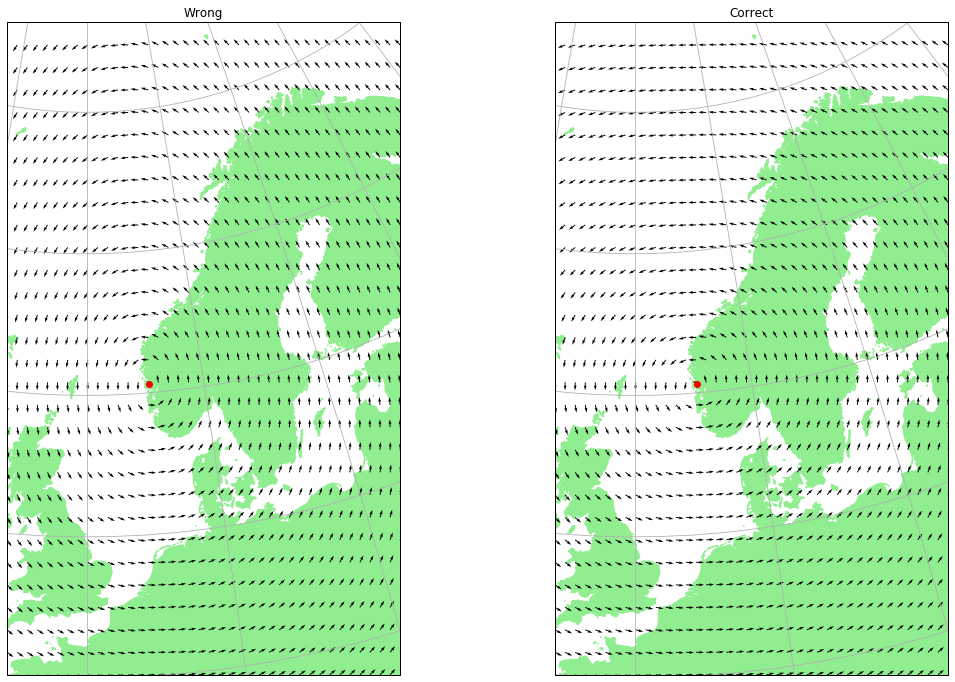

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

RES = 50 # grid resolution (number of points in east/north directions)

glat0, glon0 = 60.38, 5.34 # my vector field will circle this point

# set up map and create grid at which to define the vectors:
############################################################
extent = [-5, 20, 48, 75]
central_longitude = 0
central_latitude = (extent[-1] - extent[-2]) / 2 + extent[-2]
proj = ccrs.LambertAzimuthalEqualArea(central_latitude = central_latitude, central_longitude = central_longitude)

fig = plt.figure(figsize = (18, 12))
ax_wrong   = fig.add_subplot(121, projection = proj)
ax_correct = fig.add_subplot(122, projection = proj)

land = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                    edgecolor='face',
                                    facecolor='lightgreen')

for ax in [ax_wrong, ax_correct]:
    ax.add_feature(land, zorder=0)
    ax.gridlines()
    ax.set_extent(extent)
    ax.scatter(glon0, glat0, transform = ccrs.Geodetic(), c = 'red', marker = 'o', zorder = 5)

# use the map projection to create a grid, and calcualte the lat/lon of the grid points:
x, y = np.meshgrid( np.linspace(*(ax.get_xlim() + (RES,))), 
                    np.linspace(*(ax.get_ylim() + (RES,))))

lon, lat, _ = ccrs.Geodetic().transform_points(ax.projection, x.flatten(), y.flatten()).T


# set up the vector field: Unit vectors circling (glat0, glon0):
################################################################
lat = lat.flatten()[:, np.newaxis] # reshape to use broadcasting later
lon = lon.flatten()[:, np.newaxis]

d2r = np.pi/180
# ECEF position vectors of grid points - should be N by 3, where N is number of grid points
ecef_r_grid = np.hstack(( np.cos(lat * d2r) * np.cos(lon * d2r), np.cos(lat * d2r) * np.sin(lon * d2r), np.sin(lat * d2r) ))
    
# position vector for origin point:
ecef_r0 = np.hstack(( np.cos(glat0 * d2r) * np.cos(glon0 * d2r), np.cos(glat0 * d2r) * np.sin(glon0 * d2r), np.sin(glat0 * d2r) )).reshape((1, 3))

# unit vector pointing from origin point to grid points: - (N, 3) 
ecef_t = ecef_r0[np.newaxis, :, :] - ecef_r_grid[:, np.newaxis, :] # difference vector - not tangential yet
ecef_t = ecef_t - np.einsum('ijk,ik->ij', ecef_t, ecef_r_grid)[:, :, np.newaxis] * ecef_r_grid[:, np.newaxis, :] # subtract radial part of the vector to make it tangential
ecef_t = ecef_t/np.linalg.norm(ecef_t, axis = 2)[:, :, np.newaxis] # normalize the result
        
# make N rotation matrices to rotate ecef_t to enu_t - one rotation matrix per SECC:
R = np.hstack( (np.dstack((-np.sin(lon * d2r)                     ,  np.cos(lon * d2r)                    , np.zeros_like(lat) )),
                np.dstack((-np.cos(lon * d2r)  * np.sin(lat * d2r), -np.sin(lon * d2r) * np.sin(lat * d2r), np.cos(lat * d2r)  )),
                np.dstack(( np.cos(lon * d2r)  * np.cos(lat * d2r),  np.sin(lon * d2r) * np.cos(lat * d2r), np.sin(lat * d2r)  ))) )

# apply rotation matrices to make enu vectors pointing from grid points to origin:
enu_t = np.einsum('lij, lkj->lki', R, ecef_t)[:, :, :-1].squeeze() # remove last component (up), which should deviate from zero only by machine precicion

# the eastward vector is just a simple rotation:
vectorfield = np.vstack((enu_t[:, 1], -enu_t[:, 0]))


# plot the vectorfield:
#######################

# pretend the vector field is specified in PlateCarree projection (which is implemented in cartopy) and see what happens:
ax_wrong.quiver(lon.flatten(), lat.flatten(), vectorfield[0], vectorfield[1], transform = ccrs.PlateCarree(), scale = 50, regrid_shape = (40, 30))
ax_wrong.set_title('Wrong')

# convert vector field to PlateCarree projection, and then plot:
ve_pc, vn_pc = Geocentric_to_PlateCarree_vector_components(vectorfield[0], vectorfield[1], lat.flatten())
ax_correct.quiver(lon.flatten(), lat.flatten(), ve_pc, vn_pc, transform = ccrs.PlateCarree(), scale = 50, regrid_shape = (40, 30))
ax_correct.set_title('Correct')

plt.show()




# Example of horizontal magnetic field disturbances from Swarm measurements

In [36]:
import viresclient

from datetime import datetime as dt

data = ['B_NEC']
models = ["'CHAOS-full'     = 'CHAOS-Core' + 'CHAOS-Static' + 'CHAOS-MMA-Primary' + 'CHAOS-MMA-Secondary'"]

request = viresclient.SwarmRequest()
request.set_collection('SW_OPER_MAGA_LR_1B')
request.set_products(measurements = data, models = models, residuals = True, sampling_step="PT10S")

data = request.get_between(
        start_time=dt(2015, 3, 18, 0, 20),
        end_time=dt(2015, 3, 18, 0, 45))

data = data.as_xarray()


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.054MB)


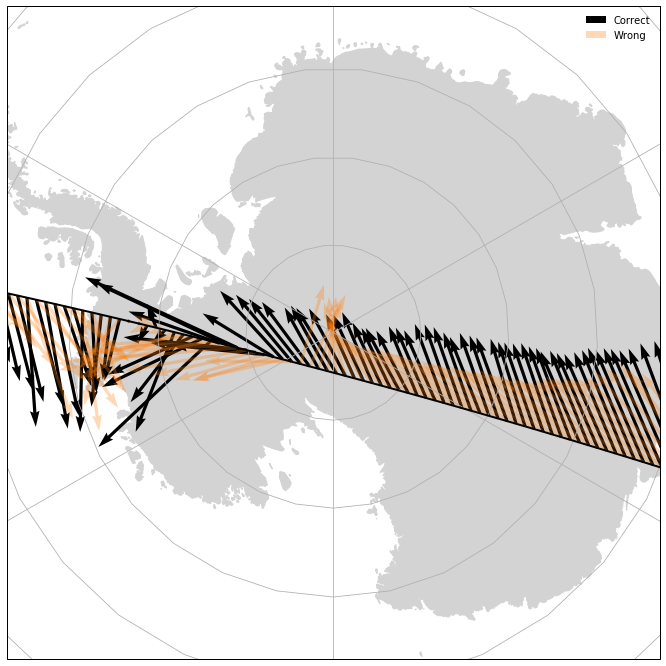

In [44]:
# set up map:
#############
proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111, projection = proj)

land = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                    edgecolor='face',
                                    facecolor='lightgrey')

ax.add_feature(land, zorder=0)
ax.gridlines()
ax.set_extent((-2500000, 2500000, -2500000, 2500000), crs=ccrs.SouthPolarStereo()) # give extent in projected coordinates since lon/lat doesnt work with this projection
ax.scatter(glon0, glat0, transform = ccrs.Geodetic(), c = 'red', marker = 'o', zorder = 5)


# plot the orbit and horizontal perturbations
#############################################

ax.plot(data['Longitude'], data['Latitude'], transform = ccrs.Geodetic(), color = 'black', linewidth = 2)

# Use the conversion trick in order to use quiver correctly with cartopy:
Be_pc, Bn_pc = Geocentric_to_PlateCarree_vector_components(data['B_NEC_res_CHAOS-full'].T[1].values, data['B_NEC_res_CHAOS-full'].T[0].values, data['Latitude'].values)
ax.quiver(data['Longitude'].values, data['Latitude'].values, Be_pc, Bn_pc, transform = ccrs.PlateCarree(), scale = 2000, label = 'Correct')

# without the correction:
ax.quiver(data['Longitude'].values, data['Latitude'].values, data['B_NEC_res_CHAOS-full'].T[1].values, data['B_NEC_res_CHAOS-full'].T[0].values, transform = ccrs.PlateCarree(), scale = 2000, alpha = .3, color = 'C1', label = 'Wrong')

ax.legend(frameon = False)

